In [1]:
include("../src/JuliaMBD.jl")

Main.JuliaMBD

In [2]:
using DifferentialEquations
using Plots
using .JuliaMBD
# import .JuliaMBD
# import .JuliaMBD: @model, @parameter, @block, @connect, @scope

In [4]:
## MSD

@model MSD begin
    @parameter begin
        M
        D
        k
        g = 9.8
    end
    @block begin
        in1 = JuliaMBD.Inport(:in1)
        out1 = JuliaMBD.Outport(:out1)
        constant1 = JuliaMBD.Constant(value = M*g)
        gain1 = JuliaMBD.Gain(K = D)
        gain2 = JuliaMBD.Gain(K = k)
        gain3 = JuliaMBD.Gain(K = 1/M)
        int1 = JuliaMBD.Integrator()
        int2 = JuliaMBD.Integrator(initialcondition = M*g/k)
        sum1 = JuliaMBD.Add(signs=[:+, :+, :-, :-])
    end
    @connect begin
        in1.out => sum1.in1
        constant1.out => sum1.in2
        gain1.out => sum1.in3
        gain2.out => sum1.in4
        sum1.out => gain3.in
        gain3.out => int1.in
        int1.out => int2.in
        int1.out => gain1.in
        int2.out => gain2.in
        int2.out => out1.in
    end
    @scope begin
        out1.in => x
        gain3.out => x2
    end
end

MSD (generic function with 1 method)

In [5]:
## test

@model Test begin
    @parameter begin
        M
        D
        k
        f
        p_cycle
        p_width
    end
    @block begin
        msd = MSD(M=M, D=D, k=k)
        pulse = JuliaMBD.PulseGenerator(amplitude=f, period=p_cycle, pulsewidth=p_width, phasedelay=10.0)
    end
    @connect begin
        pulse.out => msd.in1
    end
    @scope begin
        pulse.out => F
    end
end

Test (generic function with 1 method)

In [6]:
b = Test(M=10, D=10, k=10, f=100, p_cycle=20, p_width=50)

"Block(Test)"

In [7]:
eval(JuliaMBD.expr_sfunc(b))
eval(JuliaMBD.expr_ofunc(b))
eval(JuliaMBD.expr_ifunc(b))
eval(JuliaMBD.expr_pfunc(b))
m = JuliaMBD.ODEModel(
    b,
    eval(JuliaMBD.expr_odemodel_pfunc(b)),
    eval(JuliaMBD.expr_odemodel_ifunc(b)),
    eval(JuliaMBD.expr_odemodel_sfunc(b)),
    eval(JuliaMBD.expr_odemodel_ofunc(b))
);

  4.151388 seconds (16.64 M allocations: 932.968 MiB, 3.19% gc time, 99.78% compilation time: 10% of which was recompilation)


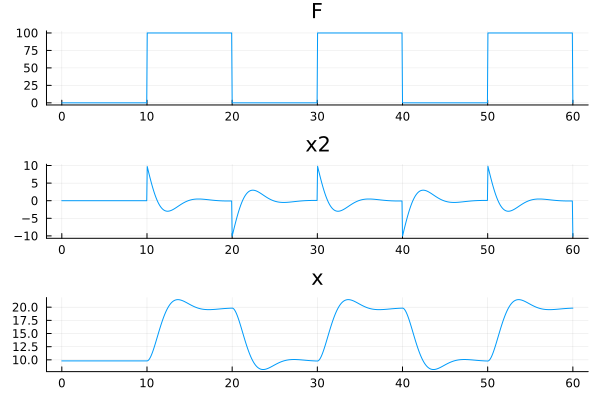

In [8]:
@time begin
    result = JuliaMBD.simulate(m, (0.0, 60.0))
    plot(result, layout=(3,1))
end